In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! kaggle competitions download -c 'fake-news'

 99% 46.0M/46.5M [00:01<00:00, 37.2MB/s]
100% 46.5M/46.5M [00:01<00:00, 24.5MB/s]


In [3]:
! ls


fake-news.zip  kaggle.json  sample_data


In [4]:
! unzip '/content/fake-news.zip'

Archive:  /content/fake-news.zip
  inflating: submit.csv              
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('/content/train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [7]:
X = df.drop(['label'], axis = 1)
y = df['label']
X.head()

,id,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [8]:
df.dropna()
df.shape


(20800, 5)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [10]:
messages = df.copy()
messages.reset_index(inplace = True)
messages.head()

,index,id,title,author,text,label
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [11]:
messages['text'][6]

'Ever wonder how Britain’s most iconic pop pianist gets through a long flight? Here are the six pictures of sharks Sir Elton John likes to stare at to pass the time on an airplane. 1. A Shark Swimming \nSit next to Elton John on a flight and you’ll see a man living in the lap of luxury, as he immediately tapes this photo of a shark darting through the ocean over his window to stare at throughout the trip. The platinum-selling artist has been known to pull his window shade down to make the shark disappear, and then quickly retract it to mark the animal’s triumphant return. He will often repeat this act dozens of times per flight. 2. A Great White Shark Leaping Into The Air \nWhen you’re an international pop sensation worth an estimated $450 million, people go the extra mile to make you happy. Flight crews are instructed to place this photo of a breaching great white in Elton John’s seat-back pocket before he even boards the plane. The five-time Grammy winner loves to pull the image out 

In [12]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
import nltk
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
ps = PorterStemmer()
corpus = []
with tf.device('/device:GPU:0'):
  for i in tqdm(range(messages.shape[0])):
    news = re.sub('[^a-zA-z]', ' ', str(messages['text'][i]))
    news = news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if word not in stopwords.words('english')]
    news = ' '.join(news)
    corpus.append(news)
  


100%|██████████| 20800/20800 [30:49<00:00, 11.25it/s]


In [17]:
tfidf_v = TfidfVectorizer(max_features = 5000, ngram_range = (1, 3))
X = tfidf_v.fit_transform(corpus).toarray()
X.shape

(20800, 5000)

In [18]:
## Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [21]:
tfidf_v.get_feature_names_out() [:20]

array(['_____', 'aaron', 'abandon', 'abc', 'abe', 'abedin', 'abil', 'abl',
       'abort', 'abroad', 'absenc', 'absolut', 'absorb', 'absurd', 'abu',
       'abus', 'academ', 'academi', 'acceler', 'accept'], dtype=object)

In [23]:
tfidf_v.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [27]:
count_df = pd.DataFrame(X_train, columns = tfidf_v.get_feature_names_out())
count_df.head()

,_____,aaron,abandon,abc,abe,abedin,abil,abl,abort,abroad,...,young,young peopl,younger,youth,youtub,zero,zika,zionist,zone,zu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.018828,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
from sklearn.naive_bayes import MultinomialNB
model1 = MultinomialNB()

In [41]:
from sklearn import metrics
model1.fit(X_train, y_train)
pred = model1.predict(X_test)
cm = metrics.confusion_matrix(y_test, pred)
print(cm)

[[3146  244]
 [ 510 2964]]


In [45]:
import matplotlib.pyplot as plt


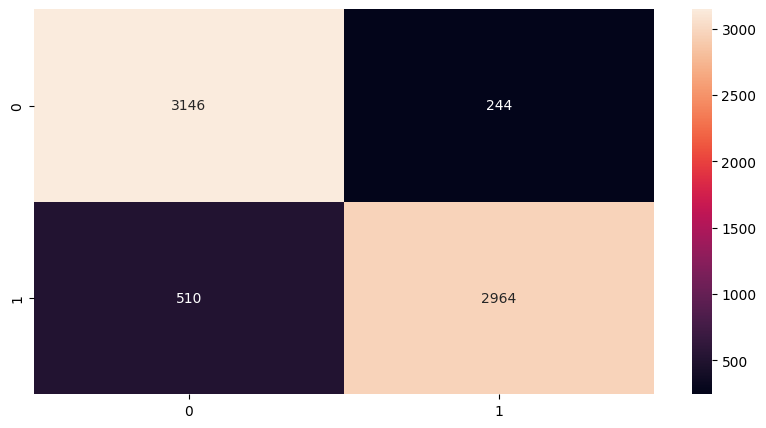

In [50]:
plt.figure(figsize = (10, 5))
import seaborn as sns
plot = sns.heatmap(cm, annot = True, fmt='g')

In [52]:
X=df.drop('label',axis=1)
y=df['label']
X.head()

,id,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [55]:
y.shape

(20800,)

In [56]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [57]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [64]:
### Vocabulary size
voc_size=5000

In [59]:
messages = X.copy()
messages.reset_index()
messages.head()

,id,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [78]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
with tf.device('/device:GPU:0'):
  for i in tqdm(range(0, len(messages))):
    news = re.sub('[^a-zA-Z]', ' ', str(messages['title'][i]))
    news = news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if word not in stopwords.words('english')]
    news = ' '.join(news)
    corpus.append(news)

100%|██████████| 20800/20800 [00:30<00:00, 677.34it/s]


In [79]:
corpus

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri',
 'jacki mason hollywood would love trump bomb north korea lack tran bathroom exclus video breitbart',
 'life life luxuri elton john favorit shark pictur stare long transcontinent flight',
 'beno hamon win french socialist parti presidenti nomin new york time',
 'excerpt draft script donald trump q ampa black church pastor new york time',
 'back channel plan ukrain russia courtesi trump associ new york time',
 'obama organ action partner soro link indivis disrupt trump agenda',
 'bbc comedi sketch real housew isi caus outrag',
 'russian research discov secret nazi militari base treasur hunter arctic photo',
 'us offici see link trump russia',
 'ye paid govern troll social media blog forum websit',
 'major leagu soccer argentin find hom

In [80]:
onehot_news = [one_hot(words, voc_size) for words in corpus]
onehot_news

[[2840, 4825, 4040, 4345, 2837, 954, 1775, 1448, 4292, 1382],
 [4348, 2454, 1935, 51, 2407, 2473, 3554],
 [3371, 519, 1398, 1426],
 [2520, 3399, 4457, 3926, 2224, 3701],
 [885, 2407, 3319, 279, 4554, 4592, 2407, 2133, 4861, 3099],
 [4429,
  3937,
  2091,
  1918,
  1735,
  365,
  3490,
  1758,
  2384,
  4499,
  1655,
  1458,
  2232,
  1037,
  3554],
 [1475, 1475, 2202, 3051, 4437, 3227, 1699, 3642, 3222, 7, 3864, 2545],
 [1083, 1661, 3126, 4413, 3118, 1974, 4354, 387, 2710, 2399, 3569],
 [30, 1476, 3216, 4225, 365, 2928, 1221, 2410, 1621, 1556, 2710, 2399, 3569],
 [4372, 4498, 82, 1853, 1467, 873, 365, 4043, 2710, 2399, 3569],
 [1848, 1967, 1779, 2071, 3301, 237, 1396, 819, 365, 2853],
 [198, 310, 215, 1281, 4863, 1330, 1654, 1149],
 [2753, 4658, 2435, 2038, 3697, 1040, 4540, 2954, 2035, 701, 3854],
 [3926, 3897, 2837, 237, 365, 1467],
 [1851, 4269, 4962, 3900, 4916, 4644, 2062, 290, 327],
 [2325, 4336, 688, 1595, 352, 3240, 3905, 2710, 2399, 3569],
 [1866, 4423, 1671, 1625, 3024, 2710,

In [81]:
senLen = 20
embedded_news = pad_sequences(onehot_news, padding = 'pre', maxlen = senLen)
print(embedded_news)

[[   0    0    0 ... 1448 4292 1382]
 [   0    0    0 ... 2407 2473 3554]
 [   0    0    0 ...  519 1398 1426]
 ...
 [   0    0    0 ... 2710 2399 3569]
 [   0    0    0 ...  432 2981 2944]
 [   0    0    0 ... 2862 3167 3445]]


In [86]:
embedding_v_features = 40
model = Sequential()
model.add(Embedding(voc_size, embedding_v_features, input_length = senLen))
model.add(LSTM(100))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 40)            200000    
                                                                 
 lstm_3 (LSTM)               (None, 100)               56400     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [83]:
import numpy as np
X_final = np.array(embedded_news)
y_final = np.array(y)
X_final.shape,y_final.shape


((20800, 20), (20800,))

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [85]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 64)

Epoch 1/10
218/218 [==============================] - 20s 81ms/step - loss: 0.3147 - accuracy: 0.8500 - val_loss: 0.1889 - val_accuracy: 0.9242
Epoch 2/10
218/218 [==============================] - 6s 26ms/step - loss: 0.1300 - accuracy: 0.9480 - val_loss: 0.1849 - val_accuracy: 0.9260
Epoch 3/10
218/218 [==============================] - 3s 12ms/step - loss: 0.0910 - accuracy: 0.9670 - val_loss: 0.2514 - val_accuracy: 0.9244
Epoch 4/10
218/218 [==============================] - 2s 10ms/step - loss: 0.0643 - accuracy: 0.9780 - val_loss: 0.2321 - val_accuracy: 0.9191
Epoch 5/10
218/218 [==============================] - 2s 8ms/step - loss: 0.0419 - accuracy: 0.9862 - val_loss: 0.2937 - val_accuracy: 0.9232
Epoch 6/10
218/218 [==============================] - 3s 14ms/step - loss: 0.0261 - accuracy: 0.9919 - val_loss: 0.3491 - val_accuracy: 0.9189
Epoch 7/10
218/218 [==============================] - 4s 19ms/step - loss: 0.0201 - accuracy: 0.9935 - val_loss: 0.3936 - val_accuracy: 0.9215

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = 